# Prediction

In [ ]:
from config import config
config = config.Configuration()

In [2]:
# run previous notebooks if necessary
if not "run_prev_notebooks" in locals(): # use case: this notebook
    run_prev_notebooks = False
    %run "1_data_preparation.ipynb"

### Model

In [3]:
from core.losses import tversky, accuracy, dice_coef, dice_loss, specificity, sensitivity
from core.optimizers import adaDelta
OPTIMIZER = adaDelta
LOSS = tversky

In [4]:
import keras
from keras.models import load_model
# check if model_path is already defined. This is the case when you run the pipeline and not this notebook alone
if not "model_path" in locals(): model_path = config.filepath_model
model = load_model(model_path, custom_objects={'tversky': LOSS, 
                                               'dice_coef': dice_coef, 
                                               'dice_loss': dice_loss, 
                                               'accuracy': accuracy , 
                                               'specificity': specificity, 
                                               'sensitivity': sensitivity}, 
                                               compile=False)

In [15]:
def inspect_arr(arr):
    print("-")
    print(f"Mean: {np.mean(arr)}")
    print(f"Avg: {np.average(arr)}")
    print(f"Min: {np.min(arr)}")
    print(f"Max: {np.max(arr)}")

### Test Prediction

In [5]:
%%time
import numpy as np
from sklearn.metrics import mean_squared_error
# predict the target on test data 
pred_test_p = model.predict(X_test) # confidence for class 0
print("Test prediction completed")

Test prediction completed
CPU times: user 42min 10s, sys: 3min 38s, total: 45min 49s
Wall time: 8min 45s


In [6]:
pred_test = (pred_test_p <= 0.97) * pred_test_p
# Root Mean Squared Error on train and test date
flattened_test = np.reshape(y_test,    np.prod(y_test.shape))
flattened_pred = np.reshape(pred_test, np.prod(pred_test.shape))
print('RMSE on test data: ', mean_squared_error(flattened_test, flattened_pred))

# np.average(pred_test_p): 0.14

RMSE on test data:  0.046950677446455216


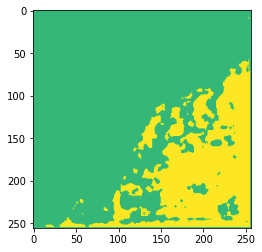

In [10]:
plt.imshow(scale_up_color_val(pred_test_p[33]))
plt.show()

### Functions

In [7]:
def scale_up_color_val(array):
    return [(num*255).astype(np.uint8) for num in array]

In [8]:
from numpy import ndarray
def show_rounded(idx):
    rounded = [ndarray.round(num, 0) for num in pred_test]
    show_rasterio(pred_test[idx])

In [9]:
from rasterio.plot import show as show_rasterio
from patch_creation import show
def show_img(idx):
    print(idx)
    print("Original")
    show(scale_up_color_val(X_test)[idx], scale_up_color_val(y_test)[idx])
    print("Prediction")
    # print("Rasterio")
    # show_rasterio(pred_test[idx])
    # print("Matplotlib")
    plt.imshow(scale_up_color_val(pred_test[idx]))
    plt.show()
    plt.imshow(scale_up_color_val(pred_test_p[idx]))
    plt.show()

In [ ]:
from patch_creation import show
def scale_up_color_val(array):
    return [(num*255).astype(np.uint8) for num in array]

def show_pred(X, y, idx):
    print(idx)
    show(scale_up_color_val(X)[idx], scale_up_color_val(y)[idx])

In [12]:
inspect_arr(pred_test_p)
inspect_arr(pred_test)

-
Mean: 0.9968584775924683
Avg: 0.9968584775924683
Min: 0.8394709825515747
Max: 1.0
-
Mean: 0.033482979983091354
Avg: 0.033482979983091354
Min: 0.0
Max: 0.9700000286102295


In [13]:
import os.path
for filename in config.pred_imgs:
    filepath = config.path_satellite + filename
    print(filepath, os.path.isfile(filepath))

/Users/leori/Desktop/BA/1_Data/2_satellite/2629BD_2018.tif True


### Create Prediction Patches

In [21]:
%%time
import os.path
filepath_pred_patches = f"{config.path_patches}pred_patches_{config.pred_imgs[0][:-4]}.npy"
# check if satellite image exists and the patches have not been generated previously
if os.path.isfile(config.path_satellite + config.pred_imgs[0]) and not os.path.isfile(filepath_pred_patches):
    %run "patch_creation_pred.py"
    print("Patches Created")

Patches Created
CPU times: user 3.36 s, sys: 6.23 s, total: 9.59 s
Wall time: 10.6 s


In [22]:
import numpy as np
filename = config.pred_imgs[0]
X_pred = np.load(filepath_pred_patches)
print(X_pred.shape)
#pred_sat = model.predict(X_pred) # confidence for class 0?

(1089, 256, 256, 3)


In [23]:
inspect_arr(X_pred)

-
Mean: 0.41817765729832335
Avg: 0.41817765729832335
Min: 0.0
Max: 0.9058823529411765


In [24]:
%%time
X_pred_l = list(X_pred)

CPU times: user 213 µs, sys: 37 µs, total: 250 µs
Wall time: 255 µs


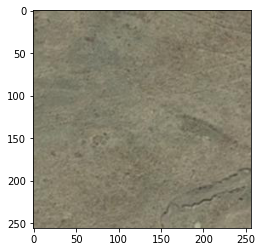

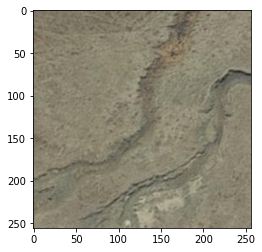

In [25]:
for x in [620, 621]:
    plt.imshow(X_pred[x])
    plt.show()

In [11]:
pred_sat = model.predict(X_pred[550])

NameError: name 'model' is not defined

In [ ]:
inspect_arr(pred_sat)

: 

In [ ]:
plt.imshow(scale_up_color_val(pred_sat))
plt.show()

: 

In [ ]:
pred_sat = model.predict(X_pred)

: 

In [ ]:
inspect_arr(pred_sat)

: 

In [ ]:
np.save(f"{config.path_data}4_pred/{config.pred_imgs[0][:-4]}.npy", pred_sat)

: 

: 

In [ ]:
x = 4500 #1448
for x in range(1600, 23000, 55):#[1500, 2000, 2500, 3000, 3500]:
    pred_test_p = model.predict(np.expand_dims(X_pred[x],0))

    import matplotlib.pyplot as plt
    plt.imshow(scale_up_color_val(X_pred[x]))
    plt.show()

    plt.imshow(scale_up_color_val(np.reshape(pred_test_p,(256, 256, 1))))
    plt.show()

: 

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(scale_up_color_val(X_pred[x]))
plt.show()

plt.imshow(scale_up_color_val(np.reshape(pred_test_p,(256, 256, 1))))
plt.show()

: 

In [ ]:
threshold = np.average(pred_test_p)
pred_test = (pred_test_p > threshold)

plt.imshow(scale_up_color_val(X_pred[x]))
plt.show()

plt.imshow(scale_up_color_val(np.reshape(pred_test_p,(256, 256, 1))))
plt.show()

: 

In [ ]:
threshold = 0.5
pred_test = (pred_test_p > threshold)

plt.imshow(scale_up_color_val(X_pred[x]))
plt.show()

plt.imshow(scale_up_color_val(np.reshape(pred_test_p,(256, 256, 1))))
plt.show()

: 

In [ ]:
X_pred.shape, np.reshape(pred_sat, pred_sat.shape[:-1]).shape

: 

In [ ]:
pred_test_p = model.predict(np.expand_dims(X_pred[1000],0))

: 

In [ ]:
for x in [1500, 20000, 10000, 5000, 15000]:
    plt.imshow(scale_up_color_val(pred_sat[x]))
    plt.show()

: 

In [ ]:
plt.imshow(np.reshape(pred_sat, pred_sat.shape[:-1]))
plt.show()

: 

In [ ]:
show_pred(X_pred, np.reshape(pred_sat, pred_sat.shape[:-1]), 1000)

: 

In [ ]:
pred_test_p = model.predict(X_pred)
np.save(f"{config.path_data}4_pred/{config.pred_imgs[0][:-4]}.npy", pred_test_p)

: 

In [ ]:
def pred_img(filename):
    X_pred = np.load(f"{config.path_patches}pred_patches_{filename[:-4]}.npy")
    print(X_pred.shape)
    pred_sat = model.predict(X_pred) # confidence for class 0?
    show_pred(X_pred, pred_sat, 4)

: 

In [ ]:
for filename in config.pred_imgs:
    pred_img(filename)

: 

In [ ]:
# merge imgs
reconstructed_image = unpatchify(X_pred, X_pred.shape) #patches, shape

: 

In [ ]:
plt.imshow(reconstructed_image)
plt.show()

: 

: 

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
# predict the target on test data 
pred_test_p = model.predict(X_test) # confidence for class 0

: 

In [ ]:
show(X_test[33], pred_test_p[33])

: 

In [ ]:
idx = 33
plt.imshow(scale_up_color_val(X_test[idx]))
plt.show()
plt.imshow(scale_up_color_val(pred_test_p[idx]))
plt.show()

: 

In [ ]:
for idx in range(900,1000,20):
    plt.imshow(scale_up_color_val(X_pred[idx]))
    plt.show()
    plt.imshow(scale_up_color_val(pred_sat[idx]))
    plt.show()

: 

In [ ]:
def pred_img(filename):
    X_pred = np.load(f"{config.path_patches}pred_patches_{filename[:-4]}.npy")
    print(X_pred.shape)
    pred_sat = model.predict(X_pred) # confidence for class 0?
    show_pred(X_pred, pred_sat, 4)

: 

In [ ]:
pred_sat.shape

: 

In [ ]:
print(np.min(pred_sat), np.max(pred_sat))

: 

: 